# PROJECT 3

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import metrics
from sklearn.svm import SVC  
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
import sklearn.metrics.cluster as smc
from matplotlib import pyplot

import os
import itertools
import random 

%matplotlib inline

random.seed(148) 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
DATA_PATH = '/content/drive/MyDrive/Project3CSm148/data/'
arp = pd.read_csv(DATA_PATH+'BrandAverageRetailPrice.csv')
brands = pd.read_csv(DATA_PATH+'BrandDetails.csv')
sales = pd.read_csv(DATA_PATH+'BrandTotalSales.csv')
units = pd.read_csv(DATA_PATH+'BrandTotalUnits.csv')
products = pd.read_csv(DATA_PATH+'Top50ProductsbyTotalSales-Timeseries.csv')

In [4]:
sales.info()
sales.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25279 entries, 0 to 25278
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Months           25279 non-null  object
 1   Brand            25279 non-null  object
 2   Total Sales ($)  25279 non-null  object
dtypes: object(3)
memory usage: 592.6+ KB


,Months,Brand,Total Sales ($)
0,09/2018,10x Infused,"1,711.334232"
1,09/2018,1964 Supply Co.,"25,475.21594500000"
2,09/2018,3 Bros Grow,"120,153.644757"
3,09/2018,3 Leaf,"6,063.5297850000000"
4,09/2018,350 Fire,"631,510.0481550000"


In [5]:
units.info()
units.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27686 entries, 0 to 27685
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Brands            27686 non-null  object 
 1   Months            27686 non-null  object 
 2   Total Units       25712 non-null  object 
 3   vs. Prior Period  24935 non-null  float64
dtypes: float64(1), object(3)
memory usage: 865.3+ KB


,Brands,Months,Total Units,vs. Prior Period
0,#BlackSeries,08/2020,"1,616.3390040000000",NaN
1,#BlackSeries,09/2020,NaN,-1.000000
2,#BlackSeries,01/2021,715.5328380000000,NaN
3,#BlackSeries,02/2021,766.669135,0.071466
4,#BlackSeries,03/2021,NaN,-1.000000


In [6]:
# TURN THE MONTHS OBJECT TO A DATETIME SO WE CAN EASILY EXTRACT THE MONTH AND YEAR
units['Months'] = pd.to_datetime(units['Months'])
sales['Months'] = pd.to_datetime(sales['Months'])
arp['Months'] = pd.to_datetime(arp['Months'])

In [7]:
# TURN THE SALES AND UNITS INTO FLOATS 
sales['Total Sales ($)'] = sales['Total Sales ($)'].str.replace(",", "")
sales['Total Sales ($)'] = sales['Total Sales ($)'].str[:8]
sales['Total Sales ($)'] = pd.to_numeric(sales["Total Sales ($)"])
units['Total Units'] = units['Total Units'].str.replace(",","")
units['Total Units'] = units['Total Units'].str[:8]
units['Total Units'] = pd.to_numeric(units["Total Units"])


In [8]:
sales.info()
sales.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25279 entries, 0 to 25278
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Months           25279 non-null  datetime64[ns]
 1   Brand            25279 non-null  object        
 2   Total Sales ($)  25279 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 592.6+ KB


,Months,Brand,Total Sales ($)
0,2018-09-01,10x Infused,1711.334
1,2018-09-01,1964 Supply Co.,25475.210
2,2018-09-01,3 Bros Grow,120153.600
3,2018-09-01,3 Leaf,6063.529
4,2018-09-01,350 Fire,631510.000


In [9]:
units.info()
units.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27686 entries, 0 to 27685
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Brands            27686 non-null  object        
 1   Months            27686 non-null  datetime64[ns]
 2   Total Units       25712 non-null  float64       
 3   vs. Prior Period  24935 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 865.3+ KB


,Brands,Months,Total Units,vs. Prior Period
0,#BlackSeries,2020-08-01,1616.3390,NaN
1,#BlackSeries,2020-09-01,NaN,-1.000000
2,#BlackSeries,2021-01-01,715.5328,NaN
3,#BlackSeries,2021-02-01,766.6691,0.071466
4,#BlackSeries,2021-03-01,NaN,-1.000000


In [10]:
units["Total Units"] = units["Total Units"].fillna(0)
units

,Brands,Months,Total Units,vs. Prior Period
0,#BlackSeries,2020-08-01,1616.3390,NaN
1,#BlackSeries,2020-09-01,0.0000,-1.000000
2,#BlackSeries,2021-01-01,715.5328,NaN
3,#BlackSeries,2021-02-01,766.6691,0.071466
4,#BlackSeries,2021-03-01,0.0000,-1.000000
...,...,...,...,...
27681,Zuma Topicals,2019-08-01,312.5153,NaN
27682,Zuma Topicals,2019-09-01,464.3063,0.485707
27683,Zuma Topicals,2019-10-01,348.0579,-0.250370
27684,Zuma Topicals,2019-11-01,135.9220,-0.609484


In [11]:
# RENAME THE PRIOR PERIOD COLUMNS SINCE THEY ARE DIFFERENT
units["Units vs. Prior Period"] = units["vs. Prior Period"]
units = units.drop(columns=['vs. Prior Period'])
arp["ARP vs. Prior Period"] = arp["vs. Prior Period"]
arp = arp.drop(columns=['vs. Prior Period'])
arp

,Brands,Months,ARP,ARP vs. Prior Period
0,#BlackSeries,2020-08-01,15.684913,NaN
1,#BlackSeries,2020-09-01,NaN,-1.000000
2,#BlackSeries,2021-01-01,13.611428,NaN
3,#BlackSeries,2021-02-01,11.873182,-0.127705
4,#BlackSeries,2021-03-01,NaN,-1.000000
...,...,...,...,...
27206,Zuma Topicals,2019-08-01,31.598214,NaN
27207,Zuma Topicals,2019-09-01,37.860964,0.198199
27208,Zuma Topicals,2019-10-01,34.546154,-0.087552
27209,Zuma Topicals,2019-11-01,36.850000,0.066689


In [12]:
all_brands = units["Brands"].unique()
all_brands

array(['#BlackSeries', '101 Cannabis Co.', '10x Infused', ..., 'Zlixir',
       'Zoma', 'Zuma Topicals'], dtype=object)

In [13]:
len(all_brands)

1640

In [14]:
data = pd.DataFrame()
for brand in all_brands:
  units_data = units[units.Brands == brand]
  # PREVIOUS MONTH: THE TOTAL UNITS OF THE PREVIOUS MONTH
  units_data.loc[:,'Previous Month'] = units_data.loc[:,'Total Units'].shift(1)
  # ROLLING AVERAGE: THE AVERAGE TOTAL UNITS OF THE PAST 3 MONTHS
  units_data.loc[:,'Rolling Average'] = (units_data.loc[:,'Total Units'].shift(3) + units_data.loc[:,'Total Units'].shift(2) + units_data.loc[:,'Total Units'].shift(1))/3

  first = units_data.first_valid_index()
  # IF THERE ARE NO, ONE, OR TWO PRIOR MONTHS, MANUALLY CALCULATE THE ROLLING AVERAGE
  units_data.loc[first,['Rolling Average']] = 0
  if units_data.shape[0] > 2:
    units_data.loc[first+2,'Rolling Average'] = (units_data.loc[first+1,'Total Units'] + units_data.loc[first, "Total Units"]) / 2
  if units_data.shape[0] > 1:
    units_data.loc[first+1,'Rolling Average'] = units_data.loc[first, "Total Units"]

  # YEAR: GET THE YEAR FROM THE MONTHS COLUMN
  units_data["Month"] = pd.DatetimeIndex(units_data["Months"]).month
  units_data['Year'] = pd.DatetimeIndex(units_data['Months']).year
  # SEASON: WINTER IS 1, SPRING IS 2, SUMMER IS 3, FALL IS 4
  units_data["Season"] = pd.DatetimeIndex(units_data['Months']).month%12 // 3 + 1

  # MERGE WITH TOTAL SALES AND ARP
  sales_data = sales[sales.Brand == brand]
  units_data = units_data.merge(sales_data, left_on='Months', right_on='Months', how ="outer")
  units_data = units_data.drop(['Brand'], 1)

  arp_data = arp[arp.Brands == brand]
  units_data = units_data.merge(arp_data, left_on='Months', right_on='Months', how ="outer")
  units_data = units_data.drop(['Brands_y', "Months"], 1)
  units_data = units_data.rename(columns={"Brands_x": "Brands"})

  units_details = brands[brands.Brand == brand]

  # INHALEABLE: IF THE BRAND HAS INHALEABLE PRODUCTS
  # EDIBLE: LIKEWISE BUT FOR EDIBLE PRODUCTS
  i = 0
  e = 0
  if 'Inhaleables' in units_details['Category L1'].values:
      i = 1
  if 'Edibles' in units_details['Category L1'].values:
      e = 1
  units_data['Inhaleable'] = i
  units_data['Edible'] = e

  # PRODUCT COUNT (NUMBER OF PRODUCTS IN BRAND DETAILS TABLE)
  units_data['Product Count'] = (units_details.Brand == brand).count()

  # MOOD SPECIFIC: IF ANY PRODUCT IS MOOD SPECIFIC
  mood_specific = 0
  if "Mood Specific" in units_details["Mood Effect"].values:
    mood_specific = 1
  units_data["Mood Specific"] = mood_specific

  # FLAVORED: IF ANY PRODUCT IS FLAVORED
  flavored = 0
  if "Flavored" in units_details["Is Flavored"].values:
    flavored = 1
  units_data["Flavored"] = flavored

  # PRODUCT TYPE: MOST COMMON TYPE (CONCENTRATES, FLOWER, PRE-ROLLED, ETC.)
  most_common_type = "None"
  lst = list(units_details["Category L2"].values)
  if lst:
    most_common_type = max(set(lst), key=lst.count)
  units_data["Predominant Product Type"] = most_common_type

  # FLAVOR: MOST COMMON FLAVOR
  # NUMBER OF FLAVORS: ALL FLAVORS OF BRAND EXCEPT NONE FLAVOR
  most_common_flavor = "None"
  num_of_flavors = 0
  lst = list(units_details["Flavor"].values)
  if lst:
    most_common_flavor = max(set(lst), key=lst.count)
    flavors = list(filter(pd.notna, lst))
    num_of_flavors = len(set(flavors))
  units_data["Predominant Flavor"] = most_common_flavor
  units_data["Predominant Flavor"] = units_data["Predominant Flavor"].fillna("None")
  units_data["Number of Flavors"] = num_of_flavors

  data = data.append(units_data, ignore_index=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [15]:
data

,Brands,Total Units,Units vs. Prior Period,Previous Month,Rolling Average,Month,Year,Season,Total Sales ($),ARP,ARP vs. Prior Period,Inhaleable,Edible,Product Count,Mood Specific,Flavored,Predominant Product Type,Predominant Flavor,Number of Flavors
0,#BlackSeries,1616.3390,NaN,NaN,0.000000,8,2020,3,25352.130,15.684913,NaN,1,0,4,0,0,Flower,None,0
1,#BlackSeries,0.0000,-1.000000,1616.3390,1616.339000,9,2020,4,NaN,NaN,-1.000000,1,0,4,0,0,Flower,None,0
2,#BlackSeries,715.5328,NaN,0.0000,808.169500,1,2021,1,9739.423,13.611428,NaN,1,0,4,0,0,Flower,None,0
3,#BlackSeries,766.6691,0.071466,715.5328,777.290600,2,2021,1,9102.802,11.873182,-0.127705,1,0,4,0,0,Flower,None,0
4,#BlackSeries,0.0000,-1.000000,766.6691,494.067300,3,2021,2,NaN,NaN,-1.000000,1,0,4,0,0,Flower,None,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27681,Zuma Topicals,312.5153,NaN,NaN,0.000000,8,2019,3,9874.926,31.598214,NaN,0,0,0,0,0,None,None,0
27682,Zuma Topicals,464.3063,0.485707,312.5153,312.515300,9,2019,4,17579.080,37.860964,0.198199,0,0,0,0,0,None,None,0
27683,Zuma Topicals,348.0579,-0.250370,464.3063,388.410800,10,2019,4,12024.060,34.546154,-0.087552,0,0,0,0,0,None,None,0
27684,Zuma Topicals,135.9220,-0.609484,348.0579,374.959833,11,2019,4,5008.728,36.850000,0.066689,0,0,0,0,0,None,None,0


In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27686 entries, 0 to 27685
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Brands                    27686 non-null  object 
 1   Total Units               27686 non-null  float64
 2   Units vs. Prior Period    24935 non-null  float64
 3   Previous Month            26046 non-null  float64
 4   Rolling Average           27686 non-null  float64
 5   Month                     27686 non-null  int64  
 6   Year                      27686 non-null  int64  
 7   Season                    27686 non-null  int64  
 8   Total Sales ($)           25279 non-null  float64
 9   ARP                       25279 non-null  float64
 10  ARP vs. Prior Period      24499 non-null  float64
 11  Inhaleable                27686 non-null  int64  
 12  Edible                    27686 non-null  int64  
 13  Product Count             27686 non-null  int64  
 14  Mood S

In [17]:
# IMPUTING TIME
# VS. PRIOR PERIOD is NULL if it is the first month of the brand being sold or if 0 units were sold in the previous month
#     SO, we can just set this value to 1
data["Units vs. Prior Period"] = data["Units vs. Prior Period"].fillna(1)
data["ARP vs. Prior Period"] = data["ARP vs. Prior Period"].fillna(1)

# PREVIOUS MONTH is NULL if this is the first month of the brand being sold
#     SO, set this value to a 0 (no units sold in previous month)
data["Previous Month"] = data["Previous Month"].fillna(0)

# TOTAL SALES ($) and ARP are NULL if no units are sold in that month for the brand
#     SO, set this value to 0
data["Total Sales ($)"] = data["Total Sales ($)"].fillna(0)
data["ARP"] = data["ARP"].fillna(0)

In [18]:
data.isna().sum().sum() # NO NULL 

0

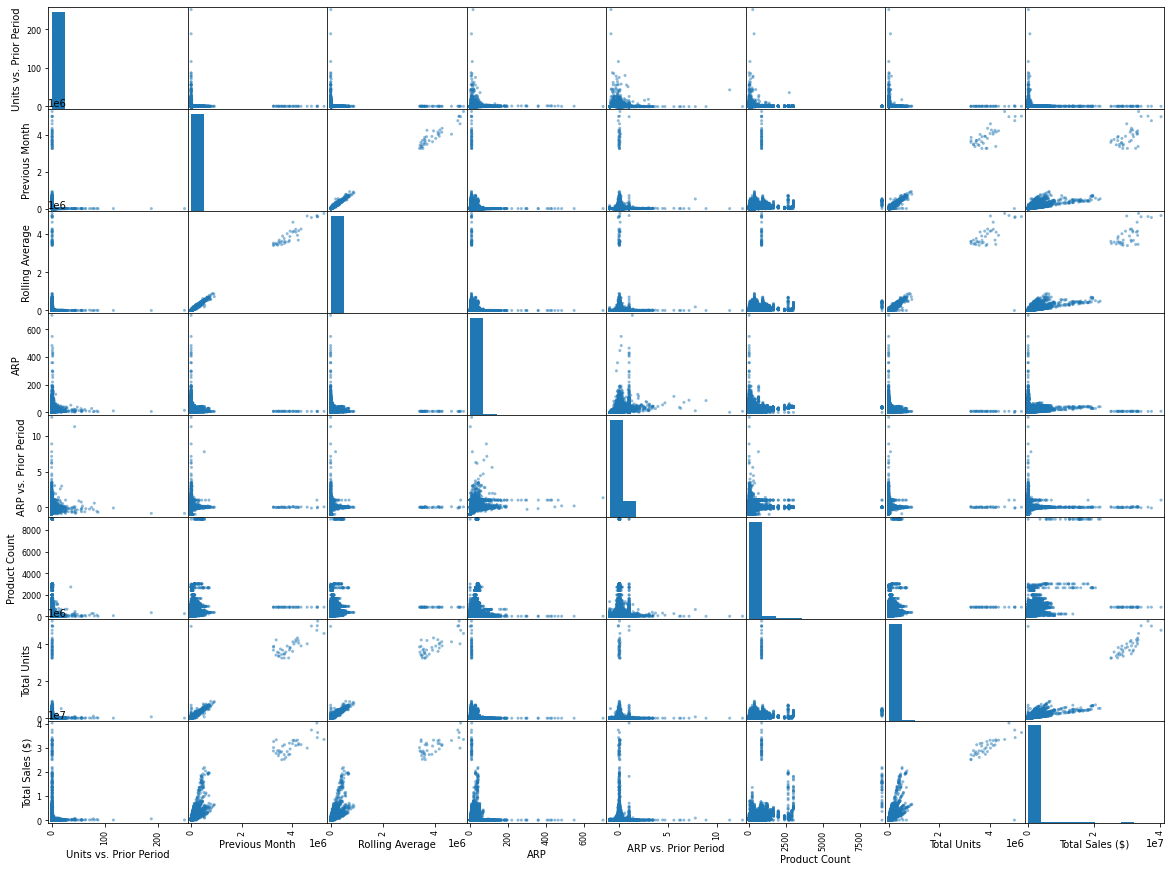

In [19]:
# CORRELATION MATRIX: MANY TIME SERIES FEATURES ARE CORRELATED
data_corr = data.corr()
from pandas.plotting import scatter_matrix
attrs = ["Units vs. Prior Period", "Previous Month", "Rolling Average", "ARP", "ARP vs. Prior Period", "Product Count", "Total Units", "Total Sales ($)"]
scatter_matrix(data[attrs], figsize=(20,15))
plt.show()

In [20]:
# WE WILL PREDICT TOTAL SALES
data_y = data["Total Sales ($)"].copy()
data_X = data.drop(columns=["Total Sales ($)", "Total Units"])
data_X

,Brands,Units vs. Prior Period,Previous Month,Rolling Average,Month,Year,Season,ARP,ARP vs. Prior Period,Inhaleable,Edible,Product Count,Mood Specific,Flavored,Predominant Product Type,Predominant Flavor,Number of Flavors
0,#BlackSeries,1.000000,0.0000,0.000000,8,2020,3,15.684913,1.000000,1,0,4,0,0,Flower,None,0
1,#BlackSeries,-1.000000,1616.3390,1616.339000,9,2020,4,0.000000,-1.000000,1,0,4,0,0,Flower,None,0
2,#BlackSeries,1.000000,0.0000,808.169500,1,2021,1,13.611428,1.000000,1,0,4,0,0,Flower,None,0
3,#BlackSeries,0.071466,715.5328,777.290600,2,2021,1,11.873182,-0.127705,1,0,4,0,0,Flower,None,0
4,#BlackSeries,-1.000000,766.6691,494.067300,3,2021,2,0.000000,-1.000000,1,0,4,0,0,Flower,None,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27681,Zuma Topicals,1.000000,0.0000,0.000000,8,2019,3,31.598214,1.000000,0,0,0,0,0,None,None,0
27682,Zuma Topicals,0.485707,312.5153,312.515300,9,2019,4,37.860964,0.198199,0,0,0,0,0,None,None,0
27683,Zuma Topicals,-0.250370,464.3063,388.410800,10,2019,4,34.546154,-0.087552,0,0,0,0,0,None,None,0
27684,Zuma Topicals,-0.609484,348.0579,374.959833,11,2019,4,36.850000,0.066689,0,0,0,0,0,None,None,0


In [22]:
# PIPELINE TIME
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.base import BaseEstimator, TransformerMixin

# cat features are Brands, Month, Year, Season, Predominant Type, Predominant Flavor
data_num = data_X.drop(["Brands", "Month", "Year", "Season", "Predominant Product Type", "Predominant Flavor"], axis=1)
numerical_features = list(data_num)
categorical_features = ["Brands", "Month", "Year", "Season", "Predominant Product Type", "Predominant Flavor"]

# num_flavors_idx, product_count_idx = 11, 8
num_flavors_idx, product_count_idx = 10, 7 # drop total units

class AugmentFeatures(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    return self
  def transform(self, X):
    flavored_products = X[:, num_flavors_idx] * X[:, product_count_idx]
    return np.c_[X, flavored_products]
#simple imputer not necessary because we already removed all nulls in dataset?
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("attribs_adder", AugmentFeatures()),
    ("std_scaler", StandardScaler())
])

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, numerical_features),
    ("cat", OneHotEncoder(handle_unknown="ignore", categories="auto"), categorical_features)
])
data_prepared = full_pipeline.fit_transform(data_X)
data_prepared

<27686x1753 sparse matrix of type '<class 'numpy.float64'>'
	with 470662 stored elements in Compressed Sparse Row format>

In [23]:
# STATISTICS
import statsmodels.api as sm
# build the OLS model (ordinary least squares) from the training data

trimmed_data_num = data_X.drop(["Brands", "Month", "Year", "Season", "Predominant Product Type", "Predominant Flavor"], axis=1)
numerical_features = list(data_num)
categorical_features = ["Month", "Year", "Season", "Predominant Product Type", "Predominant Flavor"]


full_pipeline = ColumnTransformer([
    ("num", StandardScaler(), numerical_features),
    ("cat", OneHotEncoder(handle_unknown="ignore", categories="auto"), categorical_features)
])
trimmed_data_prepared = full_pipeline.fit_transform(data_X)

avo_stats = sm.OLS(data_y, trimmed_data_prepared.toarray())

results_stats = avo_stats.fit()
print(results_stats.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


                            OLS Regression Results                            
Dep. Variable:        Total Sales ($)   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     1825.
Date:                Sat, 04 Dec 2021   Prob (F-statistic):               0.00
Time:                        22:58:47   Log-Likelihood:            -4.0508e+05
No. Observations:               27686   AIC:                         8.104e+05
Df Residuals:                   27582   BIC:                         8.112e+05
Df Model:                         103                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1          6561.9237   3309.441      1.983      0.0

In [24]:
# METRICS (FROM LIONEL CODE)
import sklearn.metrics as metrics
def regression_results(y_true, y_pred):
    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)
    print('explained_variance: ', round(explained_variance,4))    
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [25]:
# SIMPLE TRAIN TEST SPLIT ON PIPELINE DATA + BASIC LINEAR REGRESSION MODEL
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_prepared, data_y, test_size=.25, random_state=42)

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

preds = lin_reg.predict(X_test)
regression_results(y_test, preds)

explained_variance:  0.9427
r2:  0.9427
MAE:  117211.0687
MSE:  135734309451.6578
RMSE:  368421.3749


In [26]:
data_prepared.shape # HELLA DIMENSIONS

(27686, 1753)

In [27]:
# DO PCA
from sklearn.decomposition import PCA, TruncatedSVD
pca = TruncatedSVD(n_components=30) # sparse data, PCA does not work

data_pca = pca.fit_transform(data_prepared)
new_X_train, new_X_test, new_y_train, new_y_test = train_test_split(data_pca, data_y, test_size=0.25, random_state=42)

# LINEAR REGRESSION AGAIN WITH NEW PIPELINED DATA
lin_reg = LinearRegression()
lin_reg.fit(new_X_train, new_y_train)

preds = lin_reg.predict(new_X_test)
regression_results(new_y_test, preds)

explained_variance:  0.8722
r2:  0.8722
MAE:  220272.5815
MSE:  302976870546.2904
RMSE:  550433.348


In [28]:
# ENSEMBLE METHOD: RANDOM FOREST
from sklearn.ensemble import RandomForestRegressor

tree = RandomForestRegressor(min_samples_leaf=5, max_depth=100, random_state=42)

tree.fit(X_train, y_train)

preds_test = tree.predict(X_test)

regression_results(preds_test, y_test)

explained_variance:  0.9884
r2:  0.9884
MAE:  31971.5068
MSE:  27126601728.9527
RMSE:  164701.5535


In [29]:
# CROSS VALIDATE BOTH SIMPLE REGRESSION AND RANDOM FOREST
from sklearn.model_selection import  KFold
from sklearn import model_selection
from sklearn.model_selection import cross_validate, GridSearchCV, cross_val_score
import sklearn

kfold = model_selection.KFold(n_splits=5, random_state=42, shuffle=True) 
clf = LinearRegression()
scores = cross_validate(clf, data_prepared, data_y, scoring=('r2', 'neg_mean_absolute_error', 'explained_variance'), cv=kfold)

# GET MAE BY JUST MULTILPYING NMAE BY -1
print("Linear Regression MAE: " + str(( round(scores['test_neg_mean_absolute_error'].mean() * -1, 4) )))
print("Linear Regression R2: " + str(( round(scores['test_r2'].mean(), 4) )))
print("Linear Regression Explained Variance: " + str(( round(scores['test_explained_variance'].mean(), 4) )))

clf = RandomForestRegressor(max_depth=50, n_estimators=75, random_state=42)

scores = cross_validate(clf, data_prepared, data_y, scoring=('r2', 'neg_mean_absolute_error', 'explained_variance'), cv=kfold)

print("Random Forest MAE: " + str(( round(scores['test_neg_mean_absolute_error'].mean() * -1, 4) )))
print("Random Forest R2: " + str(( round(scores['test_r2'].mean(), 4) )))
print("Random Forest Explained Variance: " + str(( round(scores['test_explained_variance'].mean(), 4) )))

Linear Regression MAE: 114808.8023
Linear Regression R2: 0.935
Linear Regression Explained Variance: 0.935
Random Forest MAE: 27793.5557
Random Forest R2: 0.9898
Random Forest Explained Variance: 0.9898


As we can see, the random forest model is better; we will try to optimize the paramters of the random forest at the expense of running the cell for long.

In [ ]:
# GRID SEARCH: THIS CELL ACTUALLY TAKES LIKE 50 MINUTES
# OPTIMIZE max_depth AND n_estimators 
parameters = {'max_depth':[25, 50], 'n_estimators':[25, 50, 75, 150]}
rf = RandomForestRegressor(random_state=42)
kfold = model_selection.KFold(n_splits=3, random_state=42, shuffle=True) 
clf = GridSearchCV(rf, parameters, scoring='neg_mean_absolute_error', cv=kfold, verbose=3)
clf.fit(data_prepared, data_y)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV 1/3] END max_depth=25, n_estimators=25;, score=-31339.808 total time=  47.7s
[CV 2/3] END max_depth=25, n_estimators=25;, score=-29403.237 total time=  48.4s
[CV 3/3] END max_depth=25, n_estimators=25;, score=-34195.180 total time=  47.4s
[CV 1/3] END max_depth=25, n_estimators=50;, score=-30417.384 total time= 1.6min
[CV 2/3] END max_depth=25, n_estimators=50;, score=-28646.878 total time= 1.6min
[CV 3/3] END max_depth=25, n_estimators=50;, score=-33100.660 total time= 1.6min
[CV 1/3] END max_depth=25, n_estimators=75;, score=-30170.922 total time= 2.4min
[CV 2/3] END max_depth=25, n_estimators=75;, score=-28352.401 total time= 2.4min
[CV 3/3] END max_depth=25, n_estimators=75;, score=-32679.054 total time= 2.4min
[CV 1/3] END max_depth=25, n_estimators=150;, score=-29656.971 total time= 4.8min
[CV 2/3] END max_depth=25, n_estimators=150;, score=-27839.997 total time= 4.8min
[CV 3/3] END max_depth=25, n_estimators=150;, s

GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
             estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': [25, 50],
                         'n_estimators': [25, 50, 75, 150]},
             scoring='neg_mean_absolute_error', verbose=3)

In [ ]:
print("Best estimator: " + str(clf.best_estimator_))
print("Best score: " + str(round(-1*clf.best_score_, 4)))

Best estimator: RandomForestRegressor(max_depth=50, n_estimators=150, random_state=42)
Best score: 29597.6934


In [ ]:
# EXPERIMENT: USE SEPT 2021 AS TEST SET, 2021 AS TRAINING SET
# GET ALL BRANDS FOR 2021, FILTER OUT BRANDS THAT ARE NOT IN SEPT 2021 AND THEN SPLIT

data2021 = data[data.Year == 2021]
data2021_nosept = data2021[data.Month < 9]
brands_nosept = list(data2021_nosept.Brands.unique())
brands_nosept
len(brands_nosept)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


1135

In [ ]:
data2021_sept = data2021[data2021.Month == 9]
data2021_sept

,Brands,Total Units,Units vs. Prior Period,Previous Month,Rolling Average,Month,Year,Season,Total Sales ($),ARP,ARP vs. Prior Period,Inhaleable,Edible,Product Count,Mood Specific,Flavored,Predominant Product Type,Predominant Flavor,Number of Flavors
27,101 Cannabis Co.,483.5366,0.147842,421.2570,283.728733,9,2021,4,12276.800,25.389606,0.026253,1,0,77,0,0,Concentrates,None,0
50,11:11,1940.3680,0.485852,1305.8960,1841.375000,9,2021,4,74277.070,38.279869,-0.094711,1,0,173,0,0,Concentrates,None,0
100,1Lyfe,17504.2000,0.189840,14711.4000,11116.417000,9,2021,4,125998.500,7.198184,-0.199236,1,0,102,0,0,Flower,None,0
136,22 Red,0.0000,-1.000000,984.1616,2249.841867,9,2021,4,0.000,0.000000,-1.000000,1,0,20,0,0,Flower,None,0
244,3C Farms,11988.1700,3.218593,2841.7470,5380.730667,9,2021,4,160017.200,13.347924,0.179196,1,0,109,0,0,Flower,None,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27498,Yummi Karma,12757.2300,-0.074458,13783.5200,14165.503333,9,2021,4,458600.900,35.948296,-0.010775,0,0,244,1,0,Sublinguals,None,0
27499,Zanna,456.1666,1.000000,0.0000,0.000000,9,2021,4,3681.159,8.069769,1.000000,1,0,2,0,0,Flower,None,0
27585,Zendo Edibles,719.9865,-0.226109,930.3460,1261.215033,9,2021,4,11508.210,15.983929,-0.009880,0,0,61,1,1,Edibles,None,2
27627,Zig Zag,6688.6430,-0.184473,8201.6210,8021.726667,9,2021,4,18077.300,2.702687,-0.005564,0,0,11,0,0,Devices,None,0


In [ ]:
brands_sept = list(data2021_sept.Brands.unique())
brands_sept
len(brands_sept)

854

In [ ]:
# THE BRANDS NEED TO BE THE SAME IN BOTH THE TEST SET AND TRAIN SET OR ELSE WE WOULD USE BRANDS TO PREDICT BRANDS THAT ARE NOT IN SEPTEMBER AND VICE VERSA
for brand in brands_nosept:
  if brand not in brands_sept:
      data2021_nosept = data2021_nosept.drop(data2021_nosept.index[data2021_nosept['Brands'] == brand])

for brand in brands_sept:
  if brand not in brands_nosept:
      data2021_sept = data2021_sept.drop(data2021_sept.index[data2021_sept['Brands'] == brand])


data2021_nosept

,Brands,Total Units,Units vs. Prior Period,Previous Month,Rolling Average,Month,Year,Season,Total Sales ($),ARP,ARP vs. Prior Period,Inhaleable,Edible,Product Count,Mood Specific,Flavored,Predominant Product Type,Predominant Flavor,Number of Flavors
19,101 Cannabis Co.,250.2320,-0.259582,337.9605,644.694333,1,2021,1,8059.176,32.206812,-0.084017,1,0,77,0,0,Concentrates,None,0
20,101 Cannabis Co.,395.8241,0.581828,250.2320,345.117667,2,2021,1,13712.770,34.643599,0.075661,1,0,77,0,0,Concentrates,None,0
21,101 Cannabis Co.,686.8574,0.735259,395.8241,328.005533,3,2021,2,24347.900,35.448267,0.023227,1,0,77,0,0,Concentrates,None,0
22,101 Cannabis Co.,624.6255,-0.090604,686.8574,444.304500,4,2021,2,20784.920,33.275813,-0.061285,1,0,77,0,0,Concentrates,None,0
23,101 Cannabis Co.,345.7618,-0.446449,624.6255,569.102333,5,2021,2,12116.960,35.044264,0.053145,1,0,77,0,0,Concentrates,None,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27626,Zig Zag,8201.6210,0.031177,7953.6470,7708.604333,8,2021,3,22290.440,2.717809,-0.066344,0,0,11,0,0,Devices,None,0
27631,Zips Weed Co.,263.8763,1.000000,0.0000,2710.397567,5,2021,2,4749.104,17.997460,1.000000,1,0,23,0,0,Concentrates,None,0
27632,Zips Weed Co.,401.8849,0.523005,263.8763,376.986333,6,2021,3,7471.544,18.591250,0.032993,1,0,23,0,0,Concentrates,None,0
27633,Zips Weed Co.,600.1628,0.493370,401.8849,221.920400,7,2021,3,10964.800,18.269717,-0.017295,1,0,23,0,0,Concentrates,None,0


In [ ]:
list(data2021_nosept.Brands.unique()) == list(data2021_sept.Brands.unique())

True

In [ ]:
# NEW PIPELINE TO DROP THE MONTH, YEAR, SEASON COLUMNS SINCE WE DONT WANT TO USE DIFFERENT MONTHS/SEASONS/YEARS TO PREDICT ONLY SEPTEMBER 2021
data_num = data_X.drop(["Brands", "Month", "Year", "Season", "Predominant Product Type", "Predominant Flavor"], axis=1)
numerical_features = list(data_num)
categorical_features = ["Brands", "Predominant Product Type", "Predominant Flavor"]

new_pipeline = ColumnTransformer([
    ("num", StandardScaler(), numerical_features),
    ("cat", OneHotEncoder(handle_unknown="ignore", categories="auto"), categorical_features)
])

In [ ]:
data2021_nosept = data2021_nosept.drop(columns=["Year", "Month", "Season"])
data2021_sept = data2021_sept.drop(columns=["Year", "Month", "Season"])

data2021_nosept_X = data2021_nosept.drop(columns=["Total Sales ($)"])
data2021_nosept_y = data2021_nosept["Total Sales ($)"].copy()

data2021_sept_X = data2021_sept.drop(columns=["Total Sales ($)"])
data2021_sept_y = data2021_sept["Total Sales ($)"].copy()

prepared2021 = new_pipeline.fit_transform(data2021_nosept_X)
preparedsept = new_pipeline.fit_transform(data2021_sept_X)

lin_reg = LinearRegression()
lin_reg.fit(prepared2021, data2021_nosept_y)

preds = lin_reg.predict(preparedsept)
regression_results(data2021_sept_y, preds)

explained_variance:  0.9695
r2:  0.965
MAE:  112038.5064
MSE:  73586255515.1474
RMSE:  271267.8667


In [ ]:
tree = RandomForestRegressor(max_depth=100, n_estimators=200, random_state=42)

tree.fit(prepared2021, data2021_nosept_y)

preds_test = tree.predict(preparedsept)

regression_results(preds_test, data2021_sept_y)

explained_variance:  0.9694
r2:  0.9609
MAE:  154225.0643
MSE:  105065135433.2537
RMSE:  324137.5255


In [ ]:
# try Lasso regularization on data
from sklearn.linear_model import Lasso

l = Lasso(tol=0.001, max_iter=10000)
l.fit(X_train, y_train)

preds = l.predict(X_test)
regression_results(y_test, preds)

# NO POINT TO OPTIMIZE PARAMETERS, IT IS CLEARLY WORSE THAN RANDOM FOREST

explained_variance:  0.9428
r2:  0.9428
MAE:  116726.4519
MSE:  135690774348.5182
RMSE:  368362.2868
